# Code for Fig. 2

In [1]:
%load_ext autoreload
%autoreload 1
%aimport general_functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed

from general_functions import (compute_energies, purcell_factor, complete_dynamics, g0_fun)

The coupling between the impurity atomns and the lattice dipoles is given by $H=H_a+H_{am}+H_m$, where $H_m$ is the lattice Hamiltonian given in the previous notebook, and 

\begin{equation}
    \frac{H_a}{\hbar} = \left(\omega_a-i\frac{\Gamma_a}{2}\right)\sigma_{ee}^a,
\end{equation}
\begin{equation}
    \frac{H_{am}}{\hbar} = \sum_{i=1}^{N}\left(J_{ai} - i\frac{\sqrt{\Gamma_0\Gamma_a}}{2}\right)\sigma_{eg}^a\sigma_{ge}^i + (i\leftrightarrow a).
\end{equation}

## Semi-analytical Purcell factor (a-b, solid lines)

There is a semi-analytical method to compute the Purcell factor, denoting the coupling between the impurity atom and the lattice. Under the Markov approximation
\begin{equation}
    P_a = \frac{\frac{9d^2}{2k_0^2}\Im\left(\iint _{|\mathbf{k}|> k_0}d^2\mathbf{k}\frac{\hat{\boldsymbol{\wp}}^*_a \boldsymbol{\alpha}_\mathbf{k}(\mathbf{r}_a)\otimes \boldsymbol{\beta}_\mathbf{k}(\mathbf{r}_a)\hat{\boldsymbol{\wp}}_a}{(\omega_\mathbf{k}-\omega_\mathbf{k})/\Gamma_0}\right)}{1 + \frac{9d^2}{2k_0^2}\Im\left(\iint _{|\mathbf{k}|\leq k_0}d^2\mathbf{k}\frac{\hat{\boldsymbol{\wp}}^*_a \boldsymbol{\alpha}_\mathbf{k}(\mathbf{r}_a)\otimes \boldsymbol{\beta}_\mathbf{k}(\mathbf{r}_a)\hat{\boldsymbol{\wp}}_a}{(\omega_\mathbf{k}-\omega_\mathbf{k})/\Gamma_0}\right)},
\end{equation}
with the field eigenmodes evaluated at the impurity atom position
\begin{equation}
    \boldsymbol{\alpha}_\mathbf{k}(\mathbf{r}) = \sum_{j=1}^N\mathbf{G}_0(\mathbf{r}, \mathbf{r}_j, \omega_0)\cdot \hat{\boldsymbol{\wp}}_0e^{i\mathbf{r}_j\cdot\mathbf{k}},
\end{equation}
\begin{equation}
    \boldsymbol{\beta}_\mathbf{k}(\mathbf{r}) = \sum_{j=1}^N\hat{\boldsymbol{\wp}}_0^*\mathbf{G}_0(\mathbf{r}_j, \mathbf{r}, \omega_0)\cdot e^{-i\mathbf{r}_j\cdot\mathbf{k}}.
\end{equation}
Since we are working in the single exitation manifold, and assuming that initiallya and excitated impurity atom, the wavefunction at any time reads
\begin{align}
|\Psi(t)\rangle=\left(C_a(t)\sigma^a_{eg}+\sum_{j=1}^N C_{\mathbf{r}_j}(t)\sigma_{eg}^j\right)|\mathrm{vac}\rangle,
\end{align}
where the complex coefficients are obtained by solving the time dependent Schrödinger equation $i\hbar\partial_t|\Psi(t)\rangle = H |\Psi(t)\rangle$. Since the Hamiltonian is time indiependet, the dynamics of the system reduce to computing the matrix exponential $|\Psi(t)\rangle = e^{-i\hbar H t}|\Psi(0)\rangle$.

In [4]:
pol_lat = np.array([[0, 1, 0]]).T  # Lattice polarization
pol_emi = np.array([[1, 1, 0]]).T / np.sqrt(2)  # Impurity polarization

d = 1  # Lattice constant
lambda0 = d / 0.3  # Wave-lenght of transition
k0 = 2 * np.pi / lambda0

aho = 0.1 * d  # Cut-off in momentums

n = 2 ** 9 + 1  # Number of sites for the reciprocal lattice (total sites is N = n²)
nmax = 9  # Number of reciprocal lattice in the summatory

# Reciprocal lattice vectors
b1 = 2 * np.pi / d * np.array([1, 0])
b2 = 2 * np.pi / d * np.array([0, 1])
A = d ** 2

G0 = g0_fun(k0, aho)  # Renormalizated Green function in k = 0

k_x = np.linspace(-np.pi, np.pi, n) / d
k_X, k_Y = np.meshgrid(k_x, k_x)

k = np.vstack((k_X.flatten(), k_Y.flatten())).T

x = np.arange(0, n) - n / 2 + d / 2
y = np.arange(0, n) - n / 2 + d / 2
x, y = np.meshgrid(x, y)
z = np.zeros((n, n))
r_lat = [x, y, z]

In [5]:
# Compute the eigenenergies in momentum space
J, Gamma = compute_energies(b1, b2, A, nmax, k0, aho, k, G0=G0, polarizations=[pol_lat])
omega_k = (J - 0.5j * Gamma).reshape(n, n)

# Energy in the X-point X=(π/d, 0)
omega_q = np.real(omega_k).reshape(n, n)[n // 2, -1]  # Note that the first index is for y, and the second for x

We study the Purcell factor as the impurity attom moves in the $z$ axis. The code is written for the situation in which the impurity in on top of a dipole of the array (left figure), where $r_a = (0, 0, z)$. For the situation in which the impurity atom in in the center of a plaquette (right figure) just change the impurity position to $r_a=(0.5d, 0.5d, z)$.

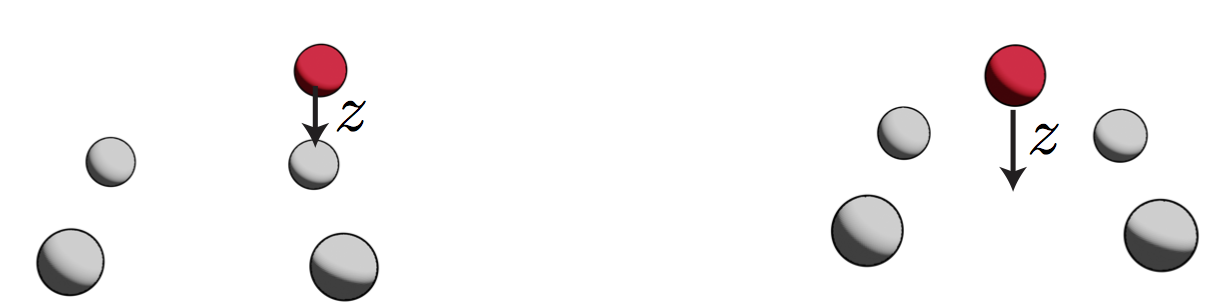

In [12]:
n_pos = 100  # Number of points to evaluate the Purcell

x_vector = np.ones(n_pos) * 0 * d
y_vector = np.ones(n_pos) * 0 * d
z_vector = np.linspace(0.1, 1.5, n_pos) * d

r_emi_vector = np.array([x_vector, y_vector, z_vector])

In [13]:
pbar = tqdm(range(n_pos), desc='Computing Purcell')  # Progress bar
# Compute the Purcell factor in parallel using all the cores of the CPU
results = Parallel(n_jobs=-1, backend='multiprocessing')(
    delayed(purcell_factor)(r_lat, r_emi_vector[:, j], [k_X, k_Y],
                            omega_k, omega_q, k0, pol_lat, pol_emi) for j in pbar)

results = np.array(results)
optical_depth = results[:, 1] / results[:, 0]

Computing Purcell:   0%|          | 0/100 [00:00<?, ?it/s]

## Numerical Purcell factor (a-b, dashed lines)

Another possibility is to compute the Purcell factor via numericall methods. For that purpose we need to compute the dynamics of the system, and then compute the expression
\begin{align}
    P(t)\approx \frac{\mathcal{P}_L(t) + L_b(t)}{L_T(t) - L_b(t)},
\end{align}
where the following quantities have been defined. The population of the lattice $\mathcal{P}_L(t)=\sum_j|C_{\mathbf{r}_j}(t)|^2$, the cumulative loss in population due to the adiabatic absorbing boundaries 
\begin{align}
    L_b(t)\approx \sum_{|\mathbf{r}_j| \geq r_{\textrm{min}}}\int_0^t dt' [\Gamma_0(\mathbf{r}_j) - \Gamma_0]|C_{\mathbf{r}_j(t')}|^2\,.
\end{align}
Finally, the total free space decay in the system is computed as
\begin{equation}
    L_T(t) =\sum_\alpha L_\alpha (t)=\sum_{\alpha} \int _0^t dt'\gamma_\alpha |\langle\phi_\alpha|\Psi(t')\rangle|^2.
\end{equation}
The value $P(t)$ converges to a finite value, which is what we define as the numerical Purcell factor $P_n = P(t\rightarrow \infty)$.

In [30]:
pol_lat = np.array([[0, 1, 0]]).T  # Lattice polarization
pol_emi = [np.array([[1, 1, 0]]).T / np.sqrt(2)]  # Impurity polarization

border = 15  # Distance from the borer of the array where the absorving boundary starts
max_gamma = 15  # Maximum extra decay rate at the borders of the lattice

d = 1  # Lattice constant
lambda0 = d / 0.3  # Wave-lenght of transition
k0 = 2 * np.pi / lambda0

# If N_x is odd, there is a lattice atom at r=(0, 0, 0)
N_x = 51  # Number of sites in the lattice in each direction (total number = N_x * N_y)
N_y = N_x
x_pos = np.arange(0, N_x) - N_x / 2 + d / 2
y_pos = np.arange(0, N_y) - N_y / 2 + d / 2
x_pos, y_pos = np.meshgrid(x_pos, y_pos)
x_pos = x_pos.flatten()
y_pos = y_pos.flatten()
z_pos = np.zeros(len(x_pos))
r_pos = [x_pos, y_pos, z_pos]

gamma_emi = 0.002  # Free space decay rate for emitter

# Transition energy for emitter
omega_emi = -0.999  # (ω_X - ω_0)/Γ_0 for  d / lambda_0 = 0.3
# omega_emi = -15.368  # (ω_X - ω_0)/Γ_0 for d / lambda_0 = 0.1

dt = 2e-3 / gamma_emi  # Time step
tf = dt * 2 ** 12  # Total time of simulation

# Initial wavefunction, with the excitation in the impurity
psi0 = np.zeros(len(x_pos) + 1)
psi0[-1] = 1

In [33]:
n_z = 106  # Number of points to evaluate the Purcell
z_emitter = np.linspace(0.1, 1.5, n_z) * d

purcell_numerical = np.zeros(n_z)
real_space_emission = np.zeros((n_z, N_y, N_x))

pbar = tqdm(total=n_z, desc='Computing dynamics')
for i in range(n_z):
    emitter = [[0, 0, z_emitter[i]]]
    
    # Compute the dynamics of the system and the numerical Purcell factor
    results = complete_dynamics(r_pos, k0, pol_lat, dt, tf, psi0, N_x, N_y, emitter, pol_emi, gamma_emi,
                      omega_emi, border, max_gamma=max_gamma)
    
    purcell_numerical[i] = results['Q_n'][-1]
    
    # Save the real space emission for the time in wich the lattice is maximally excited 
    population = np.abs(results['psi'][:, :-1].reshape((-1, N_y, N_x))) ** 2
    index_max = np.argmax(np.sum(population, axis=(1, 2)))
    real_space_emission[i] = population[index_max]
    
    pbar.update()    
pbar.close()

Computing dynamics:   0%|          | 0/106 [00:00<?, ?it/s]

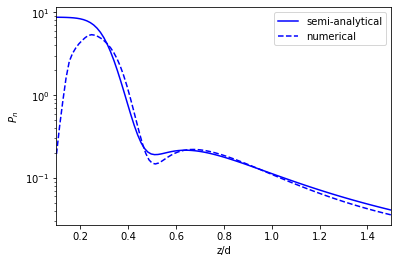

In [34]:
fig, ax = plt.subplots()

ax.plot(z_vector, optical_depth, 'b', label='semi-analytical')
ax.plot(z_emitter, purcell_numerical, 'b--', label='numerical')
ax.legend()

ax.set_xlim(min(z_emitter), max(z_emitter))

ax.set_yscale('log')

ax.set_xlabel(r'z/d')
ax.set_ylabel(r'$P_n$');

The value of z / d = 0.300


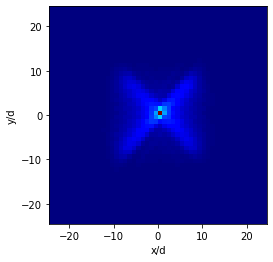

In [36]:
z_target = 0.3
index = np.argmin(np.abs(z_target - z_emitter))
print('The value of z / d = {:.3f}'.format(z_emitter[index]))

fig, ax = plt.subplots()
ax.imshow(real_space_emission[index], origin='lower', aspect='equal', cmap='jet',
          extent=[min(x_pos), max(x_pos), min(y_pos), max(y_pos)], vmin=0)

ax.set_xlabel('x/d')
ax.set_ylabel('y/d');

## Chirality (c-d)

In [5]:
pol_lat = np.array([[0, 1, 0]]).T

border = 15
max_gamma = 15
r_circles = np.arange(border, border + 5)  # Concentric circles to compute the directionality

d = 1
lambda0 = d / 0.3
k0 = 2 * np.pi / lambda0

N_x = 61
N_y = N_x
x_pos = np.arange(0, N_x) - N_x / 2 + d / 2
y_pos = np.arange(0, N_y) - N_y / 2 + d / 2
x_pos, y_pos = np.meshgrid(x_pos, y_pos)
x_pos = x_pos.flatten()
y_pos = y_pos.flatten()
z_pos = np.zeros(len(x_pos))
r_pos = [x_pos, y_pos, z_pos]

gamma_emi = 0.002
omega_emi = -0.999  # For d / lambda_0 = 0.3
# omega_emi = -15.368  # For d / lambda_0 = 0.1

emitter = [[0, 0, 0.3]]

dt = 2e-3 / gamma_emi
tf = dt * 2 ** 10

psi0 = np.zeros(len(x_pos) + 1)
psi0[-1] = 1

In [7]:
n_theta = 101
theta = np.linspace(0, 2 * np.pi, n_theta) * d

chi_1D = np.zeros(n_theta)
real_space_emission = np.zeros((n_theta, N_y, N_x))

pbar = tqdm(total=n_theta, desc='Computing dynamics')
for i in range(n_theta):    
    pol_emi = [np.array([[np.cos(theta[i]), np.sin(theta[i]), 0]]).T]
    
    # Fix the angle of reference for the directionality to π/4
    results = complete_dynamics(r_pos, k0, pol_lat, dt, tf, psi0, N_x, N_y, emitter,
                                pol_emi, gamma_emi, omega_emi, border, max_gamma=max_gamma, 
                                theta_max=np.pi / 4, r_circles=r_circles)
    
    chi_1D[i] = np.average(results['chirality'])
    
    population = np.abs(results['psi'][:, :-1].reshape((-1, N_y, N_x))) ** 2
    index_max = np.argmax(np.sum(population, axis=(1, 2)))
    real_space_emission[i] = population[index_max]
    
    pbar.update()    
pbar.close()

Computing dynamics:   0%|          | 0/101 [00:00<?, ?it/s]

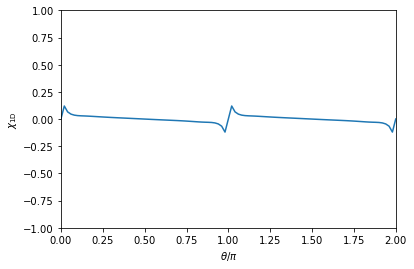

In [8]:
fig, ax = plt.subplots()
ax.plot(theta / np.pi, chi_1D)

ax.set_xlim(0, 2)
ax.set_ylim(-1, 1)

ax.set_xlabel(r'$\theta / \pi$')
ax.set_ylabel(r'$\chi_\mathrm{1D}$');

The value of theta / pi = 1.000


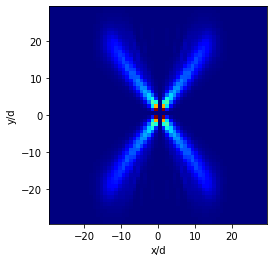

In [10]:
theta_target = np.pi
index = np.argmin(np.abs(theta_target - theta))
print('The value of theta / pi = {:.3f}'.format(theta[index] / np.pi))

fig, ax = plt.subplots()
ax.imshow(real_space_emission[index], origin='lower', aspect='equal', cmap='jet',
          extent=[min(x_pos), max(x_pos), min(y_pos), max(y_pos)], vmin=0)

ax.set_xlabel('x/d')
ax.set_ylabel('y/d');